<a href="https://colab.research.google.com/github/stef4k/train-maintenance-data-mining/blob/main/text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text classification


In [1]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
from collections import Counter
import ast


#from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, LeaveOneOut
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

Manually remove the first ';' from the first row in csv file

In [2]:
df = pd.read_csv('sncb_data_challenge.csv', delimiter=';', index_col=0)
df.sample(2)

,incident_id,vehicles_sequence,events_sequence,seconds_to_incident_sequence,approx_lat,approx_lon,train_kph_sequence,dj_ac_state_sequence,dj_dc_state_sequence,incident_type
548,4458317,"[1036, 1036, 1036, 1036, 1036, 1036, 1036, 103...","[4120, 2956, 2956, 2956, 2956, 2956, 2956, 295...","[-14370, -14345, -14260, -14257, -14234, -1422...",50.455203,4.827367,"[0.0, 15.0, 34.5, 34.4, 56.9, 45.5, 38.0, 36.7...","[False, False, False, False, False, False, Fal...","[True, True, True, True, True, True, True, Tru...",13
302,4447815,"[520, 520, 520, 520, 520, 520, 520, 520, 520, ...","[3636, 3658, 2956, 2956, 2956, 2956, 2956, 295...","[-14384, -14384, -14347, -14338, -14314, -1430...",50.844558,4.408042,"[0.0, 0.0, 9.1, 26.0, 36.8, 39.4, 41.7, 41.0, ...","[False, False, False, False, False, False, Fal...","[True, True, True, True, True, True, True, Tru...",2


Now I will analyze the percentage of each event type appearing at least once in an event sequence:

In [3]:
events_types_dict = {}
for events_sequence in df['events_sequence']:
    row_list = ast.literal_eval(events_sequence) #transforming string into actual list
    unique_events = set(row_list)
    for event in unique_events:
        if not events_types_dict.get(event):
            events_types_dict[event] = 0
        events_types_dict[event] += 1
sorted_dict = dict(sorted(events_types_dict.items(), key=lambda item: item[1], reverse=True))
# Convert the sorted dictionary to a DataFrame
sorted_events_perc_df = pd.DataFrame(list(sorted_dict.items()), columns=['event_type', 'frequency'])
sorted_events_perc_df['percentage'] = sorted_events_perc_df['frequency'] / df.shape[0] * 100
# Cast the 'event_type' column to string
sorted_events_perc_df['event_type'] = sorted_events_perc_df['event_type'].astype(str)

We save in a list all event codes that appear in less than 85% of the event sequences:

In [4]:
events_low_frequency = list(map(int, list(sorted_events_perc_df[sorted_events_perc_df.percentage<=85].event_type)))

## Text preprocessing
Before we start with text classification we need to clean the sequences of events. As seen one value of `events_sequence` contains commas and brackets even though it is a string

In [5]:
df.events_sequence.iloc[0]

'[2744, 4004, 2852, 4110, 2854, 4396, 1132, 4140, 4148, 2708, 4026, 1032, 1082, 4152, 4030, 4018, 4168, 4156, 4394, 152, 2742, 4410, 4406, 4068, 4408, 4412, 4066, 2744, 4026, 4148, 4168, 4140, 3986, 2744, 4002, 2852, 4110, 2854, 4148, 2708, 4026, 4140, 4152, 4030, 4018, 4140, 4168, 4156, 2852, 2854, 4124, 2858, 2658, 2688, 3254, 3254, 3254, 2970, 4082, 4090, 4092, 2982, 3236, 4100, 2702, 4394, 1250, 2970, 2980, 2970, 2980, 2970, 2982, 2970, 2982, 4168, 4140, 3986, 2742, 4004, 2852, 4110, 2854, 2982, 2708, 4026, 4030, 4018, 4148, 4140, 4152, 4168, 4156, 4120, 2858, 2658, 2688, 3254, 3254, 2970, 2982, 2708, 2970, 2982, 4100, 2702, 1250, 4394, 2744, 4026, 4148, 2970, 2980, 4168, 4140, 4168, 3986, 2744, 4002, 2852, 4110, 2854, 2980, 2708, 4026, 4148, 2552, 4168, 4140, 4152, 4030, 4018, 4026, 4140, 4168, 4156, 2970, 2982, 2708, 2970, 4082, 4092, 4090, 4084, 4094, 4090, 3236, 2982, 4100, 2702, 1250, 4394, 4168, 4140, 3986, 2744, 4004, 2852, 4110, 2854, 2982, 2708, 4026, 4140, 4030, 4018, 414

Also, as observed before some event types are so common they do not actually bring a lot of value (as mentioned in the paper as well). We remove those common event types

The steps to clean the event sequences are:
- keep non-common event types mentioned in list `events_low_frequency`
- remove symbols: [] , and store sequences of events as a string without brackets and commas:

In [6]:
df['clean_events_sequence'] = df.events_sequence.apply(ast.literal_eval).apply(lambda x: [i for i in x if i in events_low_frequency]).astype(str)\
                .replace(r'[\[\],]', '', regex=True)

## Text classification

Now we try to experiment using text techniques to transform the list events sequence:

In [7]:
df['incident_type'].value_counts()
df = df[~df["incident_type"].isin([7, 16, 3, 6, 17])].copy()
df.reset_index(drop=True, inplace=True)

In [8]:
target = df['incident_type'].copy() # target column separated
#le = LabelEncoder()
#target = le.fit_transform(target)
X_train, X_test, y_train, y_test = train_test_split(df.clean_events_sequence, target, test_size=0.2,  random_state=7)

Since the dataset is imbalanced we will use different strategies to battle that. Here we set a new sampling strategy based on a basic script:

In [9]:
# Define custom sampling strategy based on class distribution
# Each non-majority class will have equal samples to 15% of the majority class plus their previous samples
class_counts = pd.Series(y_train).value_counts()
max_class_count = max(class_counts.values)
sampling_strategy = {class_counts.index[i]: int(max_class_count * 0.15) + class_counts.values[i]
                     for i in range(len(pd.Series(y_train).value_counts().index)) if class_counts.values[i] < max_class_count}
sampling_strategy

{99: 183, 14: 157, 9: 131, 2: 129, 4: 97, 11: 59}

Starting with CountVectorizer:
- Tokenization: Splits text into individual words (tokens).
- Builds a Vocabulary: Creates a dictionary of unique words (tokens) from the entire corpus.
- Counts the Occurrence: Calculates the frequency (count) of each word in each document.
- Transforms Text into a Sparse Matrix: Returns a matrix of shape (n_samples, n_features), where n_samples is the number of documents and n_features is the number of unique words in the vocabulary.

  We firstly set the sampling strategy for SMOTE:

Now we set the pipeline to be used:

In [10]:
text_clf = Pipeline([
                    ('vect', CountVectorizer()),
                     #('decision_tree', DecisionTreeClassifier()),
                    ('smote', SMOTE(sampling_strategy=sampling_strategy, random_state=1, k_neighbors=2)),
                    ('extra_trees', ExtraTreesClassifier()),
                    #('random_forest', RandomForestClassifier())
                    ])

Training the model:

In [11]:
text_clf.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()),
                ('smote',
                 SMOTE(k_neighbors=2, random_state=1,
                       sampling_strategy={2: 129, 4: 97, 9: 131, 11: 59,
                                          14: 157, 99: 183})),
                ('extra_trees', ExtraTreesClassifier())])

Print the results for the particular split of test data:

In [12]:
clf_predict = text_clf.predict(X_test)
print(classification_report(y_test, clf_predict, zero_division=1))

              precision    recall  f1-score   support

           2       0.85      0.79      0.81        28
           4       0.70      0.74      0.72        19
           9       0.91      0.42      0.57        24
          11       1.00      0.00      0.00         5
          13       0.65      0.93      0.77        61
          14       0.62      0.53      0.57        30
          99       0.54      0.47      0.50        30

    accuracy                           0.68       197
   macro avg       0.75      0.55      0.56       197
weighted avg       0.70      0.68      0.65       197



In [13]:
vec = TfidfVectorizer()
embeddings = vec.fit_transform(X_train).toarray()
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=1, k_neighbors=2)
trees = ExtraTreesClassifier()
X_train_res, y_train_res = smote.fit_resample(embeddings, y_train)

trees.fit(X_train_res, y_train_res)
predictions = trees.predict(vec.transform(X_test).toarray())
print(classification_report(y_test, predictions, zero_division=1))

NameError: name 'TfidfVectorizer' is not defined

In [89]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?',
]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X_train.values)


In [52]:
vectorizer = TfidfVectorizer()
embeddings = vectorizer.fit_transform(X_train)
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=1, k_neighbors=2)
X_train_res, y_train_res = smote.fit_resample(embeddings, y_train)
le = LabelEncoder()
y_train_res_e = le.fit_transform(y_train_res)
y_test_e = le.transform(y_test)
dtrain = xgb.DMatrix(data=X_train_res, label=y_train_res_e)
dtest = xgb.DMatrix(data=vectorizer.transform(X_test), label=y_test_e)
num_classes = len(np.unique(target))
params = {
    'objective': 'multi:softmax',   # Cambiar a 'multi:softprob' si necesitas probabilidades en lugar de etiquetas
    'num_class': num_classes,       # Número de clases
    'max_depth': 4,                 # Profundidad máxima del árbol
    'learning_rate': 0.1,           # Tasa de aprendizaje
    'n_estimators': 100,            # Número de árboles
    'eval_metric': 'mlogloss'       # Métrica para clasificación multiclase
}
bst = xgb.train(params, dtrain)
predictions = bst.predict(dtest)
accuracy = accuracy_score(y_test_e, predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

NameError: name 'LabelEncoder' is not defined

In [ ]:
!pip install -U imbalanced-learn

In [105]:
df["incident_type"].value_counts()

,count
incident_type,
13,318
99,175
14,149
2,119
9,117
4,78
11,26


In [14]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN, RandomOverSampler
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from xgboost import XGBClassifier
from tqdm import tqdm
import numpy as np
import pandas as pd
from copy import deepcopy

class Experiment:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.sampling_strategies = {
            "SMOTE": SMOTE(sampling_strategy='auto', random_state=1, k_neighbors=3),
            "Borderline-SMOTE": BorderlineSMOTE(sampling_strategy='auto', random_state=1, k_neighbors=3),
            "ADASYN": ADASYN(sampling_strategy='auto', random_state=1, n_neighbors=3),
            "RandomOversampler": RandomOverSampler(sampling_strategy='auto', random_state=1),
            "SMOTE-ENN": SMOTEENN(sampling_strategy='auto', random_state=1),
            "SMOTE-Tomek": SMOTETomek(sampling_strategy='auto', random_state=1)
        }
        self.vectorizers = {
            "TFIDF": TfidfVectorizer(),
            "Count": CountVectorizer()
        }
        self.classifiers = {
            'LogisticRegression': LogisticRegression(),
            'DecisionTree': DecisionTreeClassifier(),
            'RandomForest': RandomForestClassifier(),
            'ExtraTreesClassifier': ExtraTreesClassifier(),
            'GradientBoostingClassifier': GradientBoostingClassifier(),
            'AdaBoostClassifier': AdaBoostClassifier(),
            'GaussianNB': GaussianNB(),
            'KNN': KNeighborsClassifier(),
            'SVM': SVC(probability=True),
            'XGBoost': XGBClassifier(),
        }

    def run(self):
        results = []

        for vect_name, vectorizer in self.vectorizers.items():
            i_vectorizer = deepcopy(vectorizer)
            for samp_name, sampler in self.sampling_strategies.items():
                i_sampler = deepcopy(sampler)
                for clf_name, classifier in tqdm(self.classifiers.items()):
                    print(f"\n=== Vectorizer: {vect_name} ===")
                    print(f"\n=== Sampling Strategy: {samp_name} ===")
                    print(f"\n=== Classifier: {clf_name} ===\n")

                    accuracies, recalls, precisions, f1s = [], [], [], []
                    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

                    for train_index, test_index in skf.split(self.X, self.y):
                        vectorizer = deepcopy(i_vectorizer)
                        sampler = deepcopy(i_sampler)

                        X_train, X_test = self.X[train_index], self.X[test_index]
                        y_train, y_test = self.y[train_index], self.y[test_index]

                        X_train = vectorizer.fit_transform(X_train).toarray()
                        X_test = vectorizer.transform(X_test).toarray()

                        X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)

                        classifier.fit(X_resampled, y_resampled)
                        y_pred = classifier.predict(X_test)

                        accuracies.append(accuracy_score(y_test, y_pred))
                        recalls.append(recall_score(y_test, y_pred, average='weighted'))
                        precisions.append(precision_score(y_test, y_pred, average='weighted'))
                        f1s.append(f1_score(y_test, y_pred, average='weighted'))


                    results.append({
                        'Vectorizer': vect_name,
                        'Sampling': samp_name,
                        'Model': clf_name,
                        'Accuracy Mean': np.mean(accuracies),
                        'Accuracy Std': np.std(accuracies),
                        'Recall Mean': np.mean(recalls),
                        'Recall Std': np.std(recalls),
                        'Precision Mean': np.mean(precisions),
                        'Precision Std': np.std(precisions),
                        'F1 Mean': np.mean(f1s),
                        'F1 Std': np.std(f1s),
                    })

        results_df = pd.DataFrame(results)
        return results_df

le = LabelEncoder()
target = le.fit_transform(target)
exp = Experiment(df.clean_events_sequence, target)
results = exp.run()

  0%|          | 0/10 [00:00<?, ?it/s]


=== Vectorizer: TFIDF ===

=== Sampling Strategy: SMOTE ===

=== Classifier: LogisticRegression ===



 10%|█         | 1/10 [00:07<01:10,  7.88s/it]


=== Vectorizer: TFIDF ===

=== Sampling Strategy: SMOTE ===

=== Classifier: DecisionTree ===



 20%|██        | 2/10 [00:10<00:36,  4.57s/it]


=== Vectorizer: TFIDF ===

=== Sampling Strategy: SMOTE ===

=== Classifier: RandomForest ===



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 30%|███       | 3/10 [00:15<00:35,  5.11s/it]


=== Vectorizer: TFIDF ===

=== Sampling Strategy: SMOTE ===

=== Classifier: ExtraTreesClassifier ===



 40%|████      | 4/10 [00:22<00:35,  5.84s/it]


=== Vectorizer: TFIDF ===

=== Sampling Strategy: SMOTE ===

=== Classifier: GradientBoostingClassifier ===



 50%|█████     | 5/10 [05:41<09:53, 118.70s/it]


=== Vectorizer: TFIDF ===

=== Sampling Strategy: SMOTE ===

=== Classifier: AdaBoostClassifier ===



/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1


=== Vectorizer: TFIDF ===

=== Sampling Strategy: SMOTE ===

=== Classifier: GaussianNB ===



 70%|███████   | 7/10 [05:53<02:46, 55.49s/it]


=== Vectorizer: TFIDF ===

=== Sampling Strategy: SMOTE ===

=== Classifier: KNN ===



 80%|████████  | 8/10 [05:54<01:16, 38.22s/it]


=== Vectorizer: TFIDF ===

=== Sampling Strategy: SMOTE ===

=== Classifier: SVM ===



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 90%|█████████ | 9/10 [06:25<00:35, 35.95s/it]


=== Vectorizer: TFIDF ===

=== Sampling Strategy: SMOTE ===

=== Classifier: XGBoost ===



  0%|          | 0/10 [00:00<?, ?it/s]


=== Vectorizer: TFIDF ===

=== Sampling Strategy: Borderline-SMOTE ===

=== Classifier: LogisticRegression ===



 10%|█         | 1/10 [00:03<00:34,  3.82s/it]


=== Vectorizer: TFIDF ===

=== Sampling Strategy: Borderline-SMOTE ===

=== Classifier: DecisionTree ===



 20%|██        | 2/10 [00:06<00:24,  3.11s/it]


=== Vectorizer: TFIDF ===

=== Sampling Strategy: Borderline-SMOTE ===

=== Classifier: RandomForest ===



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 30%|███       | 3/10 [00:15<00:40,  5.73s/it]


=== Vectorizer: TFIDF ===

=== Sampling Strategy: Borderline-SMOTE ===

=== Classifier: ExtraTreesClassifier ===



 40%|████      | 4/10 [00:21<00:34,  5.77s/it]


=== Vectorizer: TFIDF ===

=== Sampling Strategy: Borderline-SMOTE ===

=== Classifier: GradientBoostingClassifier ===



 50%|█████     | 5/10 [05:37<09:49, 117.92s/it]


=== Vectorizer: TFIDF ===

=== Sampling Strategy: Borderline-SMOTE ===

=== Classifier: AdaBoostClassifier ===



/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1


=== Vectorizer: TFIDF ===

=== Sampling Strategy: Borderline-SMOTE ===

=== Classifier: GaussianNB ===



 70%|███████   | 7/10 [05:50<02:46, 55.48s/it]


=== Vectorizer: TFIDF ===

=== Sampling Strategy: Borderline-SMOTE ===

=== Classifier: KNN ===



 80%|████████  | 8/10 [05:52<01:16, 38.33s/it]


=== Vectorizer: TFIDF ===

=== Sampling Strategy: Borderline-SMOTE ===

=== Classifier: SVM ===



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 90%|█████████ | 9/10 [06:22<00:35, 35.85s/it]


=== Vectorizer: TFIDF ===

=== Sampling Strategy: Borderline-SMOTE ===

=== Classifier: XGBoost ===



  0%|          | 0/10 [00:00<?, ?it/s]


=== Vectorizer: TFIDF ===

=== Sampling Strategy: ADASYN ===

=== Classifier: LogisticRegression ===



 10%|█         | 1/10 [00:03<00:34,  3.79s/it]


=== Vectorizer: TFIDF ===

=== Sampling Strategy: ADASYN ===

=== Classifier: DecisionTree ===



 20%|██        | 2/10 [00:06<00:23,  2.95s/it]


=== Vectorizer: TFIDF ===

=== Sampling Strategy: ADASYN ===

=== Classifier: RandomForest ===



 30%|███       | 3/10 [00:13<00:34,  4.93s/it]


=== Vectorizer: TFIDF ===

=== Sampling Strategy: ADASYN ===

=== Classifier: ExtraTreesClassifier ===



 40%|████      | 4/10 [00:19<00:31,  5.31s/it]


=== Vectorizer: TFIDF ===

=== Sampling Strategy: ADASYN ===

=== Classifier: GradientBoostingClassifier ===



 50%|█████     | 5/10 [05:52<10:17, 123.54s/it]/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



=== Vectorizer: TFIDF ===

=== Sampling Strategy: ADASYN ===

=== Classifier: AdaBoostClassifier ===



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algori


=== Vectorizer: TFIDF ===

=== Sampling Strategy: ADASYN ===

=== Classifier: GaussianNB ===



 70%|███████   | 7/10 [06:04<02:53, 57.84s/it]


=== Vectorizer: TFIDF ===

=== Sampling Strategy: ADASYN ===

=== Classifier: KNN ===



 80%|████████  | 8/10 [06:06<01:19, 39.87s/it]


=== Vectorizer: TFIDF ===

=== Sampling Strategy: ADASYN ===

=== Classifier: SVM ===



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 90%|█████████ | 9/10 [06:40<00:38, 38.04s/it]


=== Vectorizer: TFIDF ===

=== Sampling Strategy: ADASYN ===

=== Classifier: XGBoost ===



  0%|          | 0/10 [00:00<?, ?it/s]


=== Vectorizer: TFIDF ===

=== Sampling Strategy: RandomOversampler ===

=== Classifier: LogisticRegression ===



 10%|█         | 1/10 [00:03<00:29,  3.24s/it]


=== Vectorizer: TFIDF ===

=== Sampling Strategy: RandomOversampler ===

=== Classifier: DecisionTree ===



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 20%|██        | 2/10 [00:04<00:17,  2.16s/it]


=== Vectorizer: TFIDF ===

=== Sampling Strategy: RandomOversampler ===

=== Classifier: RandomForest ===



 30%|███       | 3/10 [00:10<00:26,  3.82s/it]


=== Vectorizer: TFIDF ===

=== Sampling Strategy: RandomOversampler ===

=== Classifier: ExtraTreesClassifier ===



 40%|████      | 4/10 [00:15<00:26,  4.36s/it]


=== Vectorizer: TFIDF ===

=== Sampling Strategy: RandomOversampler ===

=== Classifier: GradientBoostingClassifier ===



 50%|█████     | 5/10 [03:38<06:18, 75.79s/it]/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



=== Vectorizer: TFIDF ===

=== Sampling Strategy: RandomOversampler ===

=== Classifier: AdaBoostClassifier ===



/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
 60%|██████    | 6/10 [0


=== Vectorizer: TFIDF ===

=== Sampling Strategy: RandomOversampler ===

=== Classifier: GaussianNB ===



 70%|███████   | 7/10 [03:47<01:47, 35.91s/it]


=== Vectorizer: TFIDF ===

=== Sampling Strategy: RandomOversampler ===

=== Classifier: KNN ===



 80%|████████  | 8/10 [03:48<00:49, 24.69s/it]


=== Vectorizer: TFIDF ===

=== Sampling Strategy: RandomOversampler ===

=== Classifier: SVM ===



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 90%|█████████ | 9/10 [04:17<00:26, 26.09s/it]


=== Vectorizer: TFIDF ===

=== Sampling Strategy: RandomOversampler ===

=== Classifier: XGBoost ===



  0%|          | 0/10 [00:00<?, ?it/s]


=== Vectorizer: TFIDF ===

=== Sampling Strategy: SMOTE-ENN ===

=== Classifier: LogisticRegression ===



 10%|█         | 1/10 [00:03<00:32,  3.64s/it]


=== Vectorizer: TFIDF ===

=== Sampling Strategy: SMOTE-ENN ===

=== Classifier: DecisionTree ===



 20%|██        | 2/10 [00:06<00:24,  3.07s/it]


=== Vectorizer: TFIDF ===

=== Sampling Strategy: SMOTE-ENN ===

=== Classifier: RandomForest ===



 30%|███       | 3/10 [00:12<00:32,  4.71s/it]


=== Vectorizer: TFIDF ===

=== Sampling Strategy: SMOTE-ENN ===

=== Classifier: ExtraTreesClassifier ===



 40%|████      | 4/10 [00:18<00:30,  5.07s/it]


=== Vectorizer: TFIDF ===

=== Sampling Strategy: SMOTE-ENN ===

=== Classifier: GradientBoostingClassifier ===



 50%|█████     | 5/10 [04:06<07:07, 85.53s/it]


=== Vectorizer: TFIDF ===

=== Sampling Strategy: SMOTE-ENN ===

=== Classifier: AdaBoostClassifier ===



/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algori


=== Vectorizer: TFIDF ===

=== Sampling Strategy: SMOTE-ENN ===

=== Classifier: GaussianNB ===



 70%|███████   | 7/10 [04:18<02:02, 40.98s/it]


=== Vectorizer: TFIDF ===

=== Sampling Strategy: SMOTE-ENN ===

=== Classifier: KNN ===



 80%|████████  | 8/10 [04:20<00:57, 28.55s/it]


=== Vectorizer: TFIDF ===

=== Sampling Strategy: SMOTE-ENN ===

=== Classifier: SVM ===



 90%|█████████ | 9/10 [04:36<00:24, 24.39s/it]


=== Vectorizer: TFIDF ===

=== Sampling Strategy: SMOTE-ENN ===

=== Classifier: XGBoost ===



  0%|          | 0/10 [00:00<?, ?it/s]


=== Vectorizer: TFIDF ===

=== Sampling Strategy: SMOTE-Tomek ===

=== Classifier: LogisticRegression ===



 10%|█         | 1/10 [00:05<00:51,  5.76s/it]


=== Vectorizer: TFIDF ===

=== Sampling Strategy: SMOTE-Tomek ===

=== Classifier: DecisionTree ===



 20%|██        | 2/10 [00:09<00:34,  4.35s/it]


=== Vectorizer: TFIDF ===

=== Sampling Strategy: SMOTE-Tomek ===

=== Classifier: RandomForest ===



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 30%|███       | 3/10 [00:15<00:37,  5.39s/it]


=== Vectorizer: TFIDF ===

=== Sampling Strategy: SMOTE-Tomek ===

=== Classifier: ExtraTreesClassifier ===



 40%|████      | 4/10 [00:23<00:38,  6.36s/it]


=== Vectorizer: TFIDF ===

=== Sampling Strategy: SMOTE-Tomek ===

=== Classifier: GradientBoostingClassifier ===



 50%|█████     | 5/10 [05:35<09:43, 116.69s/it]


=== Vectorizer: TFIDF ===

=== Sampling Strategy: SMOTE-Tomek ===

=== Classifier: AdaBoostClassifier ===



/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1


=== Vectorizer: TFIDF ===

=== Sampling Strategy: SMOTE-Tomek ===

=== Classifier: GaussianNB ===



 70%|███████   | 7/10 [05:50<02:45, 55.30s/it]


=== Vectorizer: TFIDF ===

=== Sampling Strategy: SMOTE-Tomek ===

=== Classifier: KNN ===



 80%|████████  | 8/10 [05:52<01:16, 38.29s/it]


=== Vectorizer: TFIDF ===

=== Sampling Strategy: SMOTE-Tomek ===

=== Classifier: SVM ===



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 90%|█████████ | 9/10 [06:24<00:36, 36.49s/it]


=== Vectorizer: TFIDF ===

=== Sampling Strategy: SMOTE-Tomek ===

=== Classifier: XGBoost ===



  0%|          | 0/10 [00:00<?, ?it/s]


=== Vectorizer: Count ===

=== Sampling Strategy: SMOTE ===

=== Classifier: LogisticRegression ===



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c


=== Vectorizer: Count ===

=== Sampling Strategy: SMOTE ===

=== Classifier: DecisionTree ===



 20%|██        | 2/10 [00:09<00:34,  4.28s/it]


=== Vectorizer: Count ===

=== Sampling Strategy: SMOTE ===

=== Classifier: RandomForest ===



 30%|███       | 3/10 [00:14<00:30,  4.42s/it]


=== Vectorizer: Count ===

=== Sampling Strategy: SMOTE ===

=== Classifier: ExtraTreesClassifier ===



 40%|████      | 4/10 [00:21<00:33,  5.58s/it]


=== Vectorizer: Count ===

=== Sampling Strategy: SMOTE ===

=== Classifier: GradientBoostingClassifier ===



 50%|█████     | 5/10 [02:40<04:27, 53.44s/it]/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



=== Vectorizer: Count ===

=== Sampling Strategy: SMOTE ===

=== Classifier: AdaBoostClassifier ===



/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
 60%|██████    | 6/10 [0


=== Vectorizer: Count ===

=== Sampling Strategy: SMOTE ===

=== Classifier: GaussianNB ===



 70%|███████   | 7/10 [02:48<01:17, 25.81s/it]


=== Vectorizer: Count ===

=== Sampling Strategy: SMOTE ===

=== Classifier: KNN ===



 80%|████████  | 8/10 [02:49<00:35, 17.96s/it]


=== Vectorizer: Count ===

=== Sampling Strategy: SMOTE ===

=== Classifier: SVM ===



 90%|█████████ | 9/10 [03:31<00:25, 25.37s/it]


=== Vectorizer: Count ===

=== Sampling Strategy: SMOTE ===

=== Classifier: XGBoost ===



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  0%|          | 0/10 [00:00<?, ?it/s]


=== Vectorizer: Count ===

=== Sampling Strategy: Borderline-SMOTE ===

=== Classifier: LogisticRegression ===



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c


=== Vectorizer: Count ===

=== Sampling Strategy: Borderline-SMOTE ===

=== Classifier: DecisionTree ===



 20%|██        | 2/10 [00:08<00:32,  4.00s/it]


=== Vectorizer: Count ===

=== Sampling Strategy: Borderline-SMOTE ===

=== Classifier: RandomForest ===



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 30%|███       | 3/10 [00:16<00:39,  5.60s/it]


=== Vectorizer: Count ===

=== Sampling Strategy: Borderline-SMOTE ===

=== Classifier: ExtraTreesClassifier ===



 40%|████      | 4/10 [00:23<00:36,  6.13s/it]


=== Vectorizer: Count ===

=== Sampling Strategy: Borderline-SMOTE ===

=== Classifier: GradientBoostingClassifier ===



 50%|█████     | 5/10 [02:48<04:41, 56.23s/it]


=== Vectorizer: Count ===

=== Sampling Strategy: Borderline-SMOTE ===

=== Classifier: AdaBoostClassifier ===



/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algori


=== Vectorizer: Count ===

=== Sampling Strategy: Borderline-SMOTE ===

=== Classifier: GaussianNB ===



 70%|███████   | 7/10 [02:58<01:21, 27.33s/it]


=== Vectorizer: Count ===

=== Sampling Strategy: Borderline-SMOTE ===

=== Classifier: KNN ===



 80%|████████  | 8/10 [02:59<00:38, 19.14s/it]


=== Vectorizer: Count ===

=== Sampling Strategy: Borderline-SMOTE ===

=== Classifier: SVM ===



 90%|█████████ | 9/10 [03:40<00:25, 25.81s/it]


=== Vectorizer: Count ===

=== Sampling Strategy: Borderline-SMOTE ===

=== Classifier: XGBoost ===



  0%|          | 0/10 [00:00<?, ?it/s]


=== Vectorizer: Count ===

=== Sampling Strategy: ADASYN ===

=== Classifier: LogisticRegression ===



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c


=== Vectorizer: Count ===

=== Sampling Strategy: ADASYN ===

=== Classifier: DecisionTree ===



 20%|██        | 2/10 [00:09<00:35,  4.46s/it]


=== Vectorizer: Count ===

=== Sampling Strategy: ADASYN ===

=== Classifier: RandomForest ===



 30%|███       | 3/10 [00:15<00:34,  4.95s/it]


=== Vectorizer: Count ===

=== Sampling Strategy: ADASYN ===

=== Classifier: ExtraTreesClassifier ===



 40%|████      | 4/10 [00:22<00:34,  5.80s/it]


=== Vectorizer: Count ===

=== Sampling Strategy: ADASYN ===

=== Classifier: GradientBoostingClassifier ===



 50%|█████     | 5/10 [02:46<04:38, 55.61s/it]


=== Vectorizer: Count ===

=== Sampling Strategy: ADASYN ===

=== Classifier: AdaBoostClassifier ===



/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1


=== Vectorizer: Count ===

=== Sampling Strategy: ADASYN ===

=== Classifier: GaussianNB ===



 70%|███████   | 7/10 [02:55<01:21, 27.07s/it]


=== Vectorizer: Count ===

=== Sampling Strategy: ADASYN ===

=== Classifier: KNN ===



 80%|████████  | 8/10 [02:57<00:37, 18.93s/it]


=== Vectorizer: Count ===

=== Sampling Strategy: ADASYN ===

=== Classifier: SVM ===



 90%|█████████ | 9/10 [03:42<00:27, 27.22s/it]


=== Vectorizer: Count ===

=== Sampling Strategy: ADASYN ===

=== Classifier: XGBoost ===



  0%|          | 0/10 [00:00<?, ?it/s]


=== Vectorizer: Count ===

=== Sampling Strategy: RandomOversampler ===

=== Classifier: LogisticRegression ===



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c


=== Vectorizer: Count ===

=== Sampling Strategy: RandomOversampler ===

=== Classifier: DecisionTree ===



 20%|██        | 2/10 [00:09<00:31,  3.96s/it]


=== Vectorizer: Count ===

=== Sampling Strategy: RandomOversampler ===

=== Classifier: RandomForest ===



 30%|███       | 3/10 [00:13<00:27,  3.99s/it]


=== Vectorizer: Count ===

=== Sampling Strategy: RandomOversampler ===

=== Classifier: ExtraTreesClassifier ===



 40%|████      | 4/10 [00:19<00:28,  4.77s/it]


=== Vectorizer: Count ===

=== Sampling Strategy: RandomOversampler ===

=== Classifier: GradientBoostingClassifier ===



 50%|█████     | 5/10 [02:46<04:41, 56.34s/it]/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



=== Vectorizer: Count ===

=== Sampling Strategy: RandomOversampler ===

=== Classifier: AdaBoostClassifier ===



/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algori


=== Vectorizer: Count ===

=== Sampling Strategy: RandomOversampler ===

=== Classifier: GaussianNB ===



 70%|███████   | 7/10 [02:54<01:20, 26.72s/it]


=== Vectorizer: Count ===

=== Sampling Strategy: RandomOversampler ===

=== Classifier: KNN ===



 80%|████████  | 8/10 [02:54<00:37, 18.52s/it]


=== Vectorizer: Count ===

=== Sampling Strategy: RandomOversampler ===

=== Classifier: SVM ===



 90%|█████████ | 9/10 [03:36<00:25, 25.60s/it]


=== Vectorizer: Count ===

=== Sampling Strategy: RandomOversampler ===

=== Classifier: XGBoost ===



  0%|          | 0/10 [00:00<?, ?it/s]


=== Vectorizer: Count ===

=== Sampling Strategy: SMOTE-ENN ===

=== Classifier: LogisticRegression ===



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c


=== Vectorizer: Count ===

=== Sampling Strategy: SMOTE-ENN ===

=== Classifier: DecisionTree ===



 20%|██        | 2/10 [00:10<00:38,  4.85s/it]


=== Vectorizer: Count ===

=== Sampling Strategy: SMOTE-ENN ===

=== Classifier: RandomForest ===



 30%|███       | 3/10 [00:16<00:37,  5.29s/it]


=== Vectorizer: Count ===

=== Sampling Strategy: SMOTE-ENN ===

=== Classifier: ExtraTreesClassifier ===



 40%|████      | 4/10 [00:21<00:31,  5.24s/it]


=== Vectorizer: Count ===

=== Sampling Strategy: SMOTE-ENN ===

=== Classifier: GradientBoostingClassifier ===



 50%|█████     | 5/10 [01:41<02:40, 32.19s/it]


=== Vectorizer: Count ===

=== Sampling Strategy: SMOTE-ENN ===

=== Classifier: AdaBoostClassifier ===



/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1


=== Vectorizer: Count ===

=== Sampling Strategy: SMOTE-ENN ===

=== Classifier: GaussianNB ===



 70%|███████   | 7/10 [01:51<00:50, 16.89s/it]


=== Vectorizer: Count ===

=== Sampling Strategy: SMOTE-ENN ===

=== Classifier: KNN ===



 80%|████████  | 8/10 [01:54<00:24, 12.40s/it]


=== Vectorizer: Count ===

=== Sampling Strategy: SMOTE-ENN ===

=== Classifier: SVM ===



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m


=== Vectorizer: Count ===

=== Sampling Strategy: SMOTE-ENN ===

=== Classifier: XGBoost ===



  0%|          | 0/10 [00:00<?, ?it/s]


=== Vectorizer: Count ===

=== Sampling Strategy: SMOTE-Tomek ===

=== Classifier: LogisticRegression ===



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c


=== Vectorizer: Count ===

=== Sampling Strategy: SMOTE-Tomek ===

=== Classifier: DecisionTree ===



 20%|██        | 2/10 [00:11<00:41,  5.17s/it]


=== Vectorizer: Count ===

=== Sampling Strategy: SMOTE-Tomek ===

=== Classifier: RandomForest ===



 30%|███       | 3/10 [00:16<00:38,  5.44s/it]


=== Vectorizer: Count ===

=== Sampling Strategy: SMOTE-Tomek ===

=== Classifier: ExtraTreesClassifier ===



 40%|████      | 4/10 [00:24<00:39,  6.50s/it]


=== Vectorizer: Count ===

=== Sampling Strategy: SMOTE-Tomek ===

=== Classifier: GradientBoostingClassifier ===



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 50%|█████     | 5/10 [02:51<04:44, 56.98s/it]


=== Vectorizer: Count ===

=== Sampling Strategy: SMOTE-Tomek ===

=== Classifier: AdaBoostClassifier ===



/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1


=== Vectorizer: Count ===

=== Sampling Strategy: SMOTE-Tomek ===

=== Classifier: GaussianNB ===



 70%|███████   | 7/10 [03:00<01:22, 27.66s/it]


=== Vectorizer: Count ===

=== Sampling Strategy: SMOTE-Tomek ===

=== Classifier: KNN ===



 80%|████████  | 8/10 [03:03<00:39, 19.70s/it]


=== Vectorizer: Count ===

=== Sampling Strategy: SMOTE-Tomek ===

=== Classifier: SVM ===



 90%|█████████ | 9/10 [03:45<00:26, 26.69s/it]


=== Vectorizer: Count ===

=== Sampling Strategy: SMOTE-Tomek ===

=== Classifier: XGBoost ===



100%|██████████| 10/10 [04:09<00:00, 24.97s/it]


In [15]:
results.to_csv('results.csv')

In [ ]:
# prompt: import ExtraTreesClassifier': ExtraTreesClassifier(),
# ----> 8             'GradientBoostingClassifier': GradientBoostingClassifier(),
#       9             'AdaBoostClassifier': AdaBoostClassifier(),

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
from collections import Counter
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN, RandomOverSampler
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.ensemble import EasyEnsembleClassifier, BalancedRandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

sampling_strategies = {
    "SMOTE": SMOTE(sampling_strategy='auto', random_state=1, k_neighbors=3),
    "Borderline-SMOTE": BorderlineSMOTE(sampling_strategy='auto', random_state=1, k_neighbors=3),
    "ADASYN": ADASYN(sampling_strategy='auto', random_state=1, n_neighbors=3),
    "RandomOversampler": RandomOverSampler(sampling_strategy='auto', random_state=1),
    "SMOTE-ENN": SMOTEENN(sampling_strategy='auto', random_state=1),
    "SMOTE-Tomek": SMOTETomek(sampling_strategy='auto', random_state=1)
}

text_clf = Pipeline([
                    ('vect', CountVectorizer()),
                     #('decision_tree', DecisionTreeClassifier()),
                    ('smote', SMOTE(sampling_strategy=sampling_strategy, random_state=1, k_neighbors=2)),
                    ('extra_trees', ExtraTreesClassifier()),
                    #('random_forest', RandomForestClassifier())
                    ])
clf_predict = text_clf.predict(X_test)
print(classification_report(y_test, clf_predict, zero_division=1))
text_clf.fit(X_train, y_train)

classifiers = {
            'LogisticRegression': LogisticRegression(),
            'DecisionTree': DecisionTreeClassifier(),
            'RandomForest': RandomForestClassifier(),
            'ExtraTreesClassifier': ExtraTreesClassifier(),
            'GradientBoostingClassifier': GradientBoostingClassifier(),
            'AdaBoostClassifier': AdaBoostClassifier(),
            'GaussianNB': GaussianNB(),
            'KNN': KNeighborsClassifier(),
            'SVM': SVC(probability=True),
            'XGBoost': XGBClassifier(),
        }

le = LabelEncoder()
target_e = le.fit_transform(target)
vectorizer = TfidfVectorizer()
embeddings = vectorizer.fit_transform(df.clean_events_sequence)
results = {}

for name, sampler in tqdm(sampling_strategies.items()):
    try:
      print(f"\n=== Sampling Strategy: {name} ===")
      X_res, y_res = sampler.fit_resample(embeddings, target_e)

      experiment = SCNB()
      results[name] = experiment.evaluate_models(X_res.toarray(), y_res)
      experiment.reset_models()
    except Exception as e:
      pass

  0%|          | 0/6 [00:00<?, ?it/s]


=== Sampling Strategy: SMOTE ===



 50%|█████     | 5/10 [20:07<35:32, 426.52s/it]/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 


=== Sampling Strategy: Borderline-SMOTE ===



  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and be


=== Sampling Strategy: ADASYN ===



 50%|█████     | 5/10 [19:55<35:19, 423.97s/it]/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 


=== Sampling Strategy: RandomOversampler ===



 50%|█████     | 5/10 [13:05<23:05, 277.14s/it]/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 


=== Sampling Strategy: SMOTE-ENN ===

=== Sampling Strategy: SMOTE-Tomek ===


In [ ]:
results['RandomOversampler']

,Model,Accuracy Mean,Accuracy Std,Accuracy Median,Recall Mean,Recall Std,Recall Median,Precision Mean,Precision Std,Precision Median
0,LogisticRegression,0.860330,0.013754,0.857143,0.860330,0.013754,0.857143,0.856348,0.014742,0.852546
1,DecisionTree,0.933708,0.023858,0.937090,0.933708,0.023858,0.937090,0.934313,0.026685,0.937503
2,RandomForest,0.958340,0.019827,0.955439,0.958340,0.019827,0.955439,0.958372,0.020678,0.954634
3,ExtraTreesClassifier,0.964367,0.017822,0.965924,0.964367,0.017822,0.965924,0.966048,0.017306,0.967660
4,GradientBoostingClassifier,0.957028,0.019163,0.956750,0.957028,0.019163,0.956750,0.959100,0.017760,0.957256
5,AdaBoostClassifier,0.157743,0.043940,0.124509,0.157743,0.043940,0.124509,0.140034,0.048696,0.109705
6,GaussianNB,0.834381,0.008481,0.835079,0.834381,0.008481,0.835079,0.843843,0.012187,0.850530
7,KNN,0.837272,0.016014,0.844037,0.837272,0.016014,0.844037,0.833762,0.016173,0.841537
8,SVM,0.924008,0.012868,0.922674,0.924008,0.012868,0.922674,0.924448,0.013004,0.923317
9,XGBoost,0.963318,0.017130,0.960682,0.963318,0.017130,0.960682,0.963791,0.017740,0.960980


In [ ]:
vectorizer = TfidfVectorizer()
embeddings = vectorizer.fit_transform(df.clean_events_sequence)
class_counts = pd.Series(target).value_counts()
max_class_count = max(class_counts.values)
sampling_strategy = {class_counts.index[i]: int(max_class_count * 0.15) + class_counts.values[i]
                     for i in range(len(pd.Series(target).value_counts().index)) if class_counts.values[i] < max_class_count}
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=1, k_neighbors=2)
X_res, y_res = smote.fit_resample(embeddings, target)
le = LabelEncoder()
y_res_e = le.fit_transform(y_res)


In [ ]:
experiment = SCNB()
X_train_res, y_train_res_e = pre_process_data(X_train, y_train)
experiment.train_classifiers(X_train_res, y_train_res_e)
X_res, y_res = pre_process_data(df.clean_events_sequence, target)
experiment.evaluate_models(X_res, y_res)

All classifiers trained successfully.
Evaluation complete.


,Model,Accuracy Mean,Accuracy Std,Accuracy Median,Recall Mean,Recall Std,Recall Median,Precision Mean,Precision Std,Precision Median
0,LogisticRegression,0.742848,0.046359,0.735294,0.742848,0.046359,0.735294,0.756782,0.045676,0.753547
1,DecisionTree,0.687280,0.096798,0.650327,0.687280,0.096798,0.650327,0.696068,0.093068,0.659223
2,RandomForest,0.812945,0.079332,0.764706,0.812945,0.079332,0.764706,0.822176,0.073905,0.777173
3,GaussianNB,0.680684,0.044453,0.653595,0.680684,0.044453,0.653595,0.705803,0.038073,0.696893
4,KNN,0.638828,0.068662,0.611111,0.638828,0.068662,0.611111,0.646472,0.071641,0.630387
5,SVM,0.791280,0.040835,0.781046,0.791280,0.040835,0.781046,0.799608,0.035450,0.791265
6,XGBoost,0.811640,0.085974,0.774510,0.811640,0.085974,0.774510,0.817087,0.083693,0.783971


## Cross validation

Now we calculate the cross validation:

In [ ]:
class_counts = target.value_counts()
max_class_count = max(class_counts.values)
sampling_strategy_cross_val = {class_counts.index[i]: int(max_class_count * 0.15) + class_counts.values[i]
                     for i in range(len(y_train.value_counts().index)) if class_counts.values[i] < max_class_count}
cross_val_clf = Pipeline([
                    ('vect', CountVectorizer()),
                    ('smote', SMOTE(sampling_strategy=sampling_strategy_cross_val, random_state=1, k_neighbors=2)),
                    ('extra_trees', ExtraTreesClassifier()),
                    ])

In [ ]:
scores = cross_val_score(cross_val_clf, df.clean_events_sequence.sample(frac=1, random_state=1), target.sample(frac=1, random_state=1),
                        cv=4, scoring='accuracy',n_jobs = -1)
scores.mean()

0.6409043854696029

Create a custom scoring f1 function with zero_division parameter for cross validation to avoid nan values:

In [ ]:
# Create a custom scoring function with zero_division parameter
def custom_f1_score(y_true, y_pred):
    return f1_score(y_true, y_pred, average='weighted', zero_division=0)

# Wrap the custom scoring function using make_scorer
f1_scorer = make_scorer(custom_f1_score)

In [ ]:
scores = cross_val_score(cross_val_clf, df.clean_events_sequence.sample(frac=1, random_state=1), target.sample(frac=1, random_state=1),
                        cv=4, scoring=f1_scorer,n_jobs = -1)
print(scores)
print(scores.mean())

[0.61823676 0.61774323 0.65055584 0.57616849]
0.615676079863001


F1 is calculated as:
$$ F1 Score= 2×\frac{Precision×Recall}{Precision+Recall}
​
$$
There are some minority classes with no correct predictions ($recall=0$) resulting in a null value for the whole f1 score when using a non-custom f1 scorer

## GridsearchCV
Now we use gridsearchCV to find the optimal parameters

In [ ]:
class_counts = target.value_counts()
max_class_count = max(class_counts.values)
sampling_strategy_grid = {class_counts.index[i]: int(max_class_count * 0.15) + class_counts.values[i]
                     for i in range(len(y_train.value_counts().index)) if class_counts.values[i] < max_class_count}
sampling_strategy_grid

{99: 222,
 14: 196,
 2: 166,
 9: 164,
 4: 125,
 11: 73,
 17: 57,
 6: 53,
 3: 52,
 16: 51,
 7: 51}

In [ ]:
grid_clf = Pipeline([
                    ('vect', CountVectorizer()),
                    ('smote', SMOTE(sampling_strategy=sampling_strategy_grid, random_state=1, k_neighbors=2)),
                    ('extra_trees', ExtraTreesClassifier()),
                    ])

In [ ]:
# Define the parameter grid for GridSearchCV 15%
param_grid = {
    'vect__max_features': [500, 1000],       # Example parameter for CountVectorizer
    'vect__ngram_range': [(1, 1), (1, 2), (1,3)],   # Unigrams, bigrams, trigrams
    'extra_trees__n_estimators': [100, 200, 300, 400],        # Number of trees in ExtraTrees
    'extra_trees__max_depth': [None, 10]        # Depth of each tree
}

# Cross-validation strategy set here to replicate results
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# Define GridSearchCV with the pipeline and parameter grid
grid_search = GridSearchCV(grid_clf, param_grid, cv=cv, scoring=f1_scorer, n_jobs=-1)

# Fit GridSearchCV to the data
grid_search.fit(df.clean_events_sequence, target)

# Output the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score F1:", grid_search.best_score_)
print("Accuracy:", str(np.mean(cross_val_score(grid_search.best_estimator_, df.clean_events_sequence, target, cv=cv, scoring='accuracy'))))

Best Parameters: {'extra_trees__max_depth': None, 'extra_trees__n_estimators': 300, 'vect__max_features': 1000, 'vect__ngram_range': (1, 1)}
Best Score F1: 0.6406886229518796
Accuracy: 0.6548246439550787


In [ ]:
! pip install hmmlearn umap-learn umap-learn[plot] xgboost imbalanced-learn

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from gensim.models import Word2Vec
from hmmlearn import hmm
import umap
import umap.plot
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import ast
import xgboost as xgb
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


In [ ]:
df = pd.read_csv('sncb_data_challenge.csv', delimiter=';')
df.sample(5)

,Unnamed: 0,incident_id,vehicles_sequence,events_sequence,seconds_to_incident_sequence,approx_lat,approx_lon,train_kph_sequence,dj_ac_state_sequence,dj_dc_state_sequence,incident_type
895,895,4604847,"[537, 537, 537, 537, 537, 537, 537, 537, 537, ...","[3658, 4068, 3658, 4068, 3658, 4068, 3658, 406...","[-14388, -14257, -14222, -14127, -14090, -1381...",50.782892,4.421971,"[0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3, 0.0, ...","[False, False, False, False, False, False, Fal...","[True, True, True, True, True, True, True, Tru...",2
384,384,4451781,"[609, 609, 609, 609, 609, 609, 609, 609, 609, ...","[4068, 3658, 4068, 3658, 4066, 3658, 4068, 365...","[-14137, -14078, -13904, -13892, -13519, -1258...",50.911038,4.151967,"[0.2, 0.0, 0.1, 0.0, 0.1, 0.0, 0.1, 0.0, 0.2, ...","[False, False, False, False, False, False, Fal...","[True, True, True, True, True, True, True, Tru...",9
690,690,4465347,"[638, 638, 638, 638, 638, 638, 638, 638, 638, ...","[2742, 4002, 4110, 2708, 4026, 4148, 4140, 412...","[-8280, -8280, -8278, -8275, -8275, -8275, -82...",50.854381,2.737718,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",13
970,970,4610465,"[529, 529, 529, 529, 529, 529, 529, 529, 529, ...","[4066, 4068, 4068, 3658, 4068, 3658, 4068, 365...","[-14271, -14121, -13619, -13600, -13028, -1292...",50.720086,4.397469,"[1.6, 2.7, 3.2, 0.0, 0.1, 0.0, 1.8, 0.0, 1.0, ...","[False, False, False, False, False, False, Fal...","[True, True, True, True, True, True, True, Tru...",9
389,389,4451923,"[637, 637, 637, 637, 637, 637, 637, 637, 637, ...","[3636, 3658, 2956, 2956, 4066, 3636, 3658, 295...","[-14397, -14397, -14342, -14284, -14241, -1422...",50.805012,4.600712,"[0.0, 0.0, 31.7, 25.0, 1.9, 0.0, 0.0, 22.0, 27...","[False, False, False, False, False, False, Fal...","[True, True, True, True, True, True, True, Tru...",13


In [ ]:
events_list = []
events_pre_incident = []
events_post_incident = []

for i, (events, seconds_to_incident_sequence, vehicles_sequence, train_kph_sequence, dj_ac_state_sequence, dj_dc_state_sequence) in tqdm(enumerate(zip(df["events_sequence"],
                                                                                                                                                      df["seconds_to_incident_sequence"],
                                                                                                                                                      df["vehicles_sequence"],
                                                                                                                                                      df["train_kph_sequence"],
                                                                                                                                                      df["dj_ac_state_sequence"],
                                                                                                                                                      df["dj_dc_state_sequence"])), total=len(df)):
    events = ast.literal_eval(events)
    seconds_to_incident_sequence = ast.literal_eval(seconds_to_incident_sequence)
    vehicles_sequence = ast.literal_eval(vehicles_sequence)
    train_kph_sequence = ast.literal_eval(train_kph_sequence)
    dj_ac_state_sequence = ast.literal_eval(dj_ac_state_sequence)
    dj_dc_state_sequence = ast.literal_eval(dj_dc_state_sequence)


    pre_incidents = []
    pre_incidents_vehicles = []
    pre_incidents_kph = []
    pre_incidents_ac = []
    pre_incidents_dc = []


    post_incidents = []
    post_incidents_vehicles = []
    post_incidents_kph = []
    post_incidents_ac = []
    post_incidents_dc = []

    event_seq = []
    prev_event = 0

    for event, time_to_incident, vehicle, kph, ac, dc in zip(events, seconds_to_incident_sequence, vehicles_sequence, train_kph_sequence, dj_ac_state_sequence, dj_dc_state_sequence):
      #if event != prev_event:
      event_seq.append(str(event))
      if time_to_incident <= 0:
          pre_incidents.append(str(event))
          pre_incidents_vehicles.append(str(vehicle))
          pre_incidents_kph.append(str(kph))
          pre_incidents_ac.append(str(ac))
          pre_incidents_dc.append(str(dc))
      else:
          post_incidents.append(str(event))
          post_incidents_vehicles.append(str(vehicle))
          post_incidents_kph.append(str(kph))
          post_incidents_ac.append(str(ac))
          post_incidents_dc.append(str(dc))
      #prev_event = event

    # Append the pre and post incident lists to the main lists
    events_pre_incident.append(pre_incidents)
    events_post_incident.append(post_incidents)
    events_list.append(event_seq)

100%|██████████| 1011/1011 [00:15<00:00, 64.88it/s] 


In [ ]:
from itertools import combinations
tuples_post = []
tuples_pre = []

for post_events in tqdm(events_post_incident):
  prev_post_event = 0
  for post_event in post_events:
    if prev_post_event != 0:
      tup = [prev_post_event, post_event]
      prev_post_event = post_event
      if tup not in tuples_post:
        tuples_post.append(tup)
    else:
      prev_post_event = post_event

for pre_events in tqdm(events_pre_incident):
  prev_pre_event = 0
  for pre_event in pre_events:
    if prev_pre_event != 0:
      tup = [prev_pre_event, pre_event]
      prev_pre_event = pre_event
      if tup not in tuples_pre:
        tuples_pre.append(tup)
    else:
      prev_pre_event = pre_event

100%|██████████| 1011/1011 [00:10<00:00, 97.33it/s]


In [ ]:
c = 0
for post in tuples_post:
  if post in tuples_pre:
    c += 1
c/len(tuples_post)

0.4953556864521976

In [ ]:
c = 0
for pre in tuples_pre:
  if pre in tuples_post:
    c += 1
c/len(tuples_pre)

0.4728078711212023

In [ ]:
cleaned_events_pre_incident = []
tuples_removed = 0

for prev_events in tqdm(events_pre_incident):
  cleaned_events = []
  prev_pre_event = 0
  for pre_event in prev_events:
    if prev_pre_event != 0:
      tup = [prev_pre_event, pre_event]
      if tup not in tuples_post:
        cleaned_events.append(prev_pre_event)
      else:
        tuples_removed += 1
    else:
      prev_pre_event = pre_event
  cleaned_events.append(pre_event)
  cleaned_events_pre_incident.append(cleaned_events)
cleaned_events_pre_incident[0]

100%|██████████| 1011/1011 [01:07<00:00, 14.95it/s]


In [ ]:
from tqdm import tqdm

cleaned_events_pre_incident = []
tuples_removed = 0

for prev_events in tqdm(events_pre_incident):
    cleaned_events = []
    prev_pre_event = None  # Usa None para identificar el primer elemento

    for pre_event in prev_events:
        if prev_pre_event is not None:
            tup = [prev_pre_event, pre_event]

            if tup not in tuples_post:
                cleaned_events.append(prev_pre_event)
            else:
                tuples_removed += 1

        prev_pre_event = pre_event

    if prev_pre_event is not None:
        cleaned_events.append(prev_pre_event)
    cleaned_events_pre_incident.append(cleaned_events)

cleaned_events_pre_incident[0]


100%|██████████| 1011/1011 [00:16<00:00, 60.09it/s]


['1132',
 '4026',
 '1082',
 '2742',
 '4092',
 '2982',
 '1250',
 '1250',
 '2982',
 '4394',
 '2708',
 '3036',
 '3986']

In [ ]:
tuples_removed

191311

In [ ]:
df.groupby("incident_type").count()["incident_id"]

,incident_id
incident_type,
2,119
3,5
4,78
6,6
7,4
9,117
11,26
13,318
14,149


In [ ]:
lens = []
for events in cleaned_events_pre_incident:
  lens.append(len(events))
print(np.mean(lens))

9.22650840751731


In [ ]:
vector_size = 4
word2vec = Word2Vec(sentences=cleaned_events_pre_incident, vector_size=vector_size, window=9, sg=1, min_count=4, workers=-1)
embeddings = []
labels = df["incident_type"]
actual_events = []

for events in tqdm(cleaned_events_pre_incident):
  embedding = np.zeros(vector_size)
  denominator = 0
  for event in events:
    if event in word2vec.wv:
      embedding += word2vec.wv[event]
      denominator += 1

  embeddings.append(embedding)

100%|██████████| 1011/1011 [00:00<00:00, 24517.17it/s]


In [ ]:
encoders = {
            'CountVectorizer': CountVectorizer(),
            'TfidfVectorizer': TfidfVectorizer()
        }
embedding_methods = {}
data = [" ".join(sentence) for sentence in events_pre_incident]
for name, encoder in tqdm(encoders.items()):
    embedding_methods[name] = encoder.fit_transform(data).toarray()

100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


<Axes: >

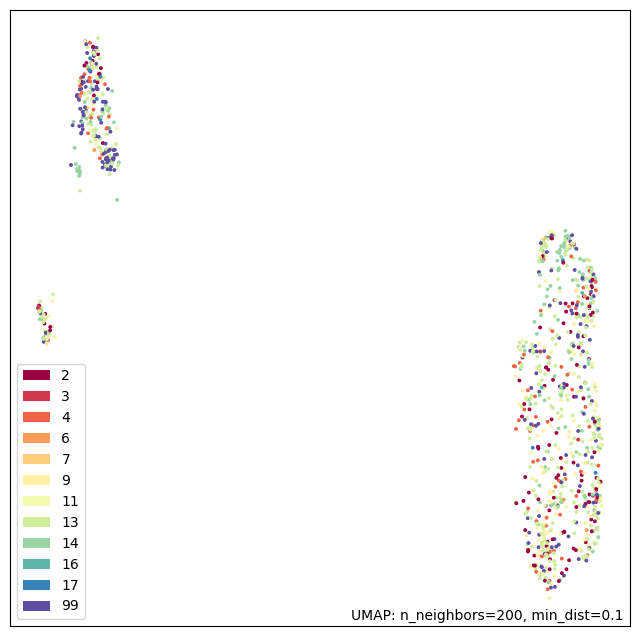

In [ ]:
umap_model = umap.UMAP(n_components=2, min_dist=0.1, n_neighbors=200, metric='euclidean')
X_umap = umap_model.fit_transform(embedding_methods["TfidfVectorizer"])
umap.plot.points(umap_model, labels=df["incident_type"])

In [ ]:
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import pandas as pd

# Load the data
X = embedding_methods["TfidfVectorizer"]
y = encoded_labels

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert y_train to a Series to easily compute class counts
y_train_series = pd.Series(y_train)
class_counts = y_train_series.value_counts()
max_class_count = max(class_counts.values)

# Define the sampling strategy for SMOTE
sampling_strategy = {cls: int(max_class_count * 0.20) + count
                     for cls, count in class_counts.items() if count < max_class_count}

print('Original training dataset shape:', Counter(y_train))

# Apply SMOTE only to the training set
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=1, k_neighbors=2)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print('Resampled training dataset shape:', Counter(y_train_res))
print('Original test dataset shape:', Counter(y_test))


Original training dataset shape: Counter({7: 254, 11: 130, 8: 118, 0: 99, 5: 95, 2: 68, 6: 18, 10: 7, 3: 6, 1: 5, 9: 4, 4: 4})
Resampled training dataset shape: Counter({7: 254, 11: 180, 8: 168, 0: 149, 5: 145, 2: 118, 6: 68, 10: 57, 3: 56, 1: 55, 9: 54, 4: 54})
Original test dataset shape: Counter({7: 64, 11: 45, 8: 31, 5: 22, 0: 20, 2: 10, 6: 8, 10: 3})


In [ ]:
embeddings = CountVectorizer().fit_transform(X_train).toarray()
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=1, k_neighbors=2)
X_train_res, y_train_res = smote.fit_resample(embeddings, y_train)
X_test_res = CountVectorizer().fit_transform(X_test).toarray()


In [ ]:
dtrain = xgb.DMatrix(data=X_train_res, label=y_train_res)
dtest = xgb.DMatrix(data=X_test_res, label=y_test)
num_classes = len(np.unique(labels))
params = {
    'objective': 'multi:softmax',   # Cambiar a 'multi:softprob' si necesitas probabilidades en lugar de etiquetas
    'num_class': num_classes,       # Número de clases
    'max_depth': 4,                 # Profundidad máxima del árbol
    'learning_rate': 0.1,           # Tasa de aprendizaje
    'n_estimators': 100,            # Número de árboles
    'eval_metric': 'mlogloss'       # Métrica para clasificación multiclase
}
num_rounds = 100
#bst = xgb.train(params, dtrain, num_rounds)
bst = ExtraTreesClassifier().fit(X_train_res, y_train_res)
predictions = bst.predict(X_test_res)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(classification_report(y_test, predictions))

ValueError: X has 576 features, but ExtraTreesClassifier is expecting 864 features as input.

In [ ]:
class SCNB:
    def __init__(self):
        self.classifiers = {
            'LogisticRegression': LogisticRegression(),
            'DecisionTree': DecisionTreeClassifier(),
            'RandomForest': RandomForestClassifier(),
            'ExtraTreesClassifier': ExtraTreesClassifier(),
            'GradientBoostingClassifier': GradientBoostingClassifier(),
            'AdaBoostClassifier': AdaBoostClassifier(),
            'GaussianNB': GaussianNB(),
            'KNN': KNeighborsClassifier(),
            'SVM': SVC(probability=True),
            'XGBoost': XGBClassifier(),
        }
        self.models = {}
        self.embedding_methods = {}
        self.ensemble_model = None
        self.hmm_model = None

    def train_classifiers(self, X, y):
        """Entrena cada clasificador popular junto con XGBoost."""
        for name, clf in self.classifiers.items():
            clf.fit(X, y)
            self.models[name] = clf
        print("All classifiers trained successfully.")

    def reset_models(self):
        self.classifiers = {
            'LogisticRegression': LogisticRegression(),
            'DecisionTree': DecisionTreeClassifier(),
            'RandomForest': RandomForestClassifier(),
            'ExtraTreesClassifier': ExtraTreesClassifier(),
            'GradientBoostingClassifier': GradientBoostingClassifier(),
            'AdaBoostClassifier': AdaBoostClassifier(),
            'GaussianNB': GaussianNB(),
            'KNN': KNeighborsClassifier(),
            'SVM': SVC(probability=True),
            'XGBoost': XGBClassifier(),
        }

    def generate_embeddings(self, words_list):
        """Genera embeddings para una lista de palabras usando distintos encoders."""
        encoders = {
            'CountVectorizer': CountVectorizer(),
            'OneHotEncoder': OneHotEncoder(sparse=False),
            'TfidfVectorizer': TfidfVectorizer()
        }

        for name, encoder in encoders.items():
            self.embedding_methods[name] = encoder.fit_transform(words_list).toarray()

        word2vec_model = Word2Vec(sentences=[words_list], vector_size=100, window=5, min_count=1, workers=4)
        self.embedding_methods['Word2Vec'] = [word2vec_model.wv[word] for word in words_list if word in word2vec_model.wv]
        print("Embeddings generated successfully.")

    def evaluate_models(self, X, y):
        results = []
        skf = StratifiedKFold(n_splits=5)

        for name, model in tqdm(self.classifiers.items()):
            accuracies, recalls, precisions = [], [], []
            for train_index, test_index in skf.split(X, y):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]

                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)

                accuracies.append(accuracy_score(y_test, y_pred))
                recalls.append(recall_score(y_test, y_pred, average='weighted'))
                precisions.append(precision_score(y_test, y_pred, average='weighted'))

            results.append({
                'Model': name,
                'Accuracy Mean': np.mean(accuracies),
                'Accuracy Std': np.std(accuracies),
                'Accuracy Median': np.median(accuracies),
                'Recall Mean': np.mean(recalls),
                'Recall Std': np.std(recalls),
                'Recall Median': np.median(recalls),
                'Precision Mean': np.mean(precisions),
                'Precision Std': np.std(precisions),
                'Precision Median': np.median(precisions),
            })

        results_df = pd.DataFrame(results)
        return results_df

    def train_ensemble_model(self, weights=None):
        """Crea y entrena un modelo de ensamblaje usando los mejores modelos entrenados."""
        estimators = [(name, model) for name, model in self.models.items()]
        self.ensemble_model = VotingClassifier(estimators=estimators, voting='soft', weights=weights)
        print("Ensemble model created successfully.")

    def train_hidden_markov_model(self, X, n_components=2):
        """Entrena un modelo Hidden Markov."""
        self.hmm_model = hmm.GaussianHMM(n_components=n_components)
        self.hmm_model.fit(X)
        print("Hidden Markov Model trained successfully.")

    def analyze_hmm(self):
        """Analiza el modelo Hidden Markov mostrando matrices de transición y demás estadísticas."""
        if self.hmm_model:
            print("Transition matrix:", self.hmm_model.transmat_)
            print("Means:", self.hmm_model.means_)
            print("Covars:", self.hmm_model.covars_)
        else:
            print("HMM model not trained yet.")

    def dimensionality_reduction_with_umap(self, X, y, min_dist_values=[0.1, 0.5], n_neighbors_values=[5, 10]):
        """Aplica reducción de dimensionalidad usando UMAP y muestra scatter plots."""
        for min_dist in min_dist_values:
            for n_neighbors in n_neighbors_values:
                umap_model = umap.UMAP(min_dist=min_dist, n_neighbors=n_neighbors)
                X_umap = umap_model.fit_transform(X)

                scatter_matrix(pd.DataFrame(X_umap), alpha=0.2, figsize=(10, 10), diagonal='kde', c=y)
                plt.title(f"UMAP Clustering (min_dist={min_dist}, n_neighbors={n_neighbors})")
                plt.show()

        print("Dimensionality reduction with UMAP completed.")

    def clustering_with_algorithms(self, X, y):
        """Realiza clustering usando algoritmos populares y muestra scatter plots."""
        clusterers = {
            'KMeans': KMeans(n_clusters=len(np.unique(y))),
            'Agglomerative': AgglomerativeClustering(n_clusters=len(np.unique(y))),
            'DBSCAN': DBSCAN()
        }

        for name, clusterer in clusterers.items():
            clusters = clusterer.fit_predict(X)
            plt.figure(figsize=(8, 6))
            scatter_matrix(pd.DataFrame(X), alpha=0.2, figsize=(10, 10), diagonal='kde', c=clusters)
            plt.title(f"Clustering with {name}")
            plt.show()

        print("Clustering with various algorithms completed.")


In [ ]:
# Ejemplo de uso
# Supongamos que tienes un DataFrame `df` con variables `X` y `y` definidas.

# Crear instancia de SCNB
scnb = SCNB()

# Entrenar clasificadores
X = df.drop(columns=['target'])
y = df['target']
scnb.train_classifiers(X, y)

# Generar embeddings para una lista de palabras
words_list = ["gato", "perro", "pez", "pájaro"]
scnb.generate_embeddings(words_list)

# Evaluar modelos
results_df = scnb.evaluate_models(X, y)
print(results_df)

# Entrenar modelo de ensamblaje
scnb.train_ensemble_model()

# Entrenar y analizar un modelo HMM
scnb.train_hidden_markov_model(X)
scnb.analyze_hmm()

# Red
